In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.stats import ttest_ind
from scipy.stats import linregress
import statsmodels.api as sm
from sklearn.impute import KNNImputer
import seaborn as sn
from fuzzywuzzy import process
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import imgkit

/Users/nandipatioohasripriya/anaconda3/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
df = pd.read_excel('Dataset spreadsheet.xlsx')

In [3]:

html_str = df.head().to_html()

# Save the HTML to an image

In [4]:
basic_stats = df.describe()
print(f"Basic Statistics: \n{basic_stats}\n")

Basic Statistics: 
             TemP  Time (min)          PS          BET         PV          C  \
count   86.000000   86.000000   85.000000    86.000000  85.000000  83.000000   
mean   566.453488  151.347287   13.908847   191.444442   0.152331  57.293855   
std    170.921148  126.607738   38.958862   298.769825   0.180884  20.399065   
min    300.000000    0.100000    1.320000     0.479000   0.001000   9.460000   
25%    450.000000   60.000000    2.880000     7.100000   0.020000  41.490000   
50%    500.000000  120.000000    4.440000    59.090000   0.100000  60.000000   
75%    700.000000  150.000000    9.850000   295.500000   0.230000  74.195000   
max    950.000000  480.000000  213.290000  1838.860000   1.030000  89.570000   

               H          O  
count  82.000000  83.000000  
mean    1.927890  16.469048  
std     1.648728  11.025043  
min     0.000000   0.670000  
25%     0.834000  10.100000  
50%     1.630000  14.030000  
75%     2.622500  21.755000  
max    10.300000  55

In [5]:
df.isna().sum()

Biomass       1
TP            0
TemP          0
Time (min)    0
PS            1
BET           0
PV            1
C             3
H             4
N             6
O             3
Qm (mg/g)     0
dtype: int64

In [6]:
df.dtypes

Biomass        object
TP             object
TemP            int64
Time (min)    float64
PS            float64
BET           float64
PV            float64
C             float64
H             float64
N              object
O             float64
Qm (mg/g)      object
dtype: object

In [7]:
#converting object to float for N , Qm (mg/g) variables
df['N'] = pd.to_numeric(df['N'], errors='coerce')
df['Qm (mg/g)'] = pd.to_numeric(df['Qm (mg/g)'] , errors='coerce')

In [8]:
numeric_columns = ['TemP', 'Time (min)', 'PS', 'BET', 'PV', 'C','N', 'H', 'O' , 'Qm (mg/g)']
#creating a new dataframe
df_to_impute = df[numeric_columns]
impute = KNNImputer(n_neighbors = 2)
imputed_array = impute.fit_transform(df_to_impute)
#replacing original columns with imputed one's
df[numeric_columns] = imputed_array
#Verify the updated DataFrame
print(df.head())

                     Biomass          TP   TemP  Time (min)    PS     BET  \
0       Waste sludge (paper)  Citalopram  315.0       150.0  9.82    3.43   
1       Waste sludge (paper)  Citalopram  600.0        10.0  1.37   94.39   
2       Waste sludge (paper)  Citalopram  800.0        10.0  1.37  120.86   
3  Waste sludge (Biological)  Citalopram  800.0       150.0  1.41  209.12   
4  Waste sludge (Biological)  Citalopram  800.0        10.0  3.69   10.82   

     PV      C     H     N      O  Qm (mg/g)  
0  0.02  30.84  2.14  0.43  20.32        4.4  
1  0.06  30.69  0.96  0.32  20.41        3.8  
2  0.08  28.81  0.47  0.33  19.29        8.5  
3  0.13  27.05  0.82  0.33   9.73       19.6  
4  0.02  35.35  0.72  2.47   2.01        4.3  


In [9]:
df.isna().sum()

Biomass       1
TP            0
TemP          0
Time (min)    0
PS            0
BET           0
PV            0
C             0
H             0
N             0
O             0
Qm (mg/g)     0
dtype: int64

In [10]:
df[df['Biomass'].isnull()]

,Biomass,TP,TemP,Time (min),PS,BET,PV,C,H,N,O,Qm (mg/g)
70,NaN,Tetracycline,600.0,60.0,3.823,319.8,0.537,73.35,2.57,2.57,0.67,157.69


In [11]:
# Forward fill the Biomass column because Sludge (pharmaceutical) is shared with two rows.
df['Biomass'] = df['Biomass'].fillna(method='ffill')
df[df['Biomass'].isnull()]


,Biomass,TP,TemP,Time (min),PS,BET,PV,C,H,N,O,Qm (mg/g)


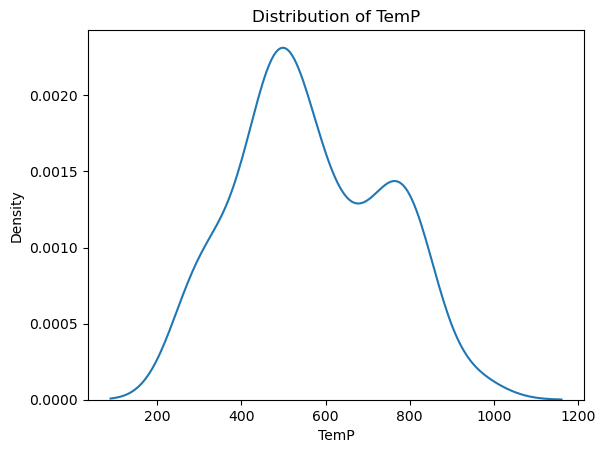

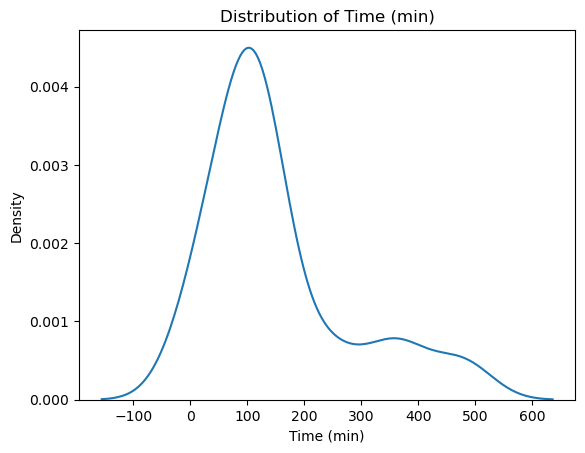

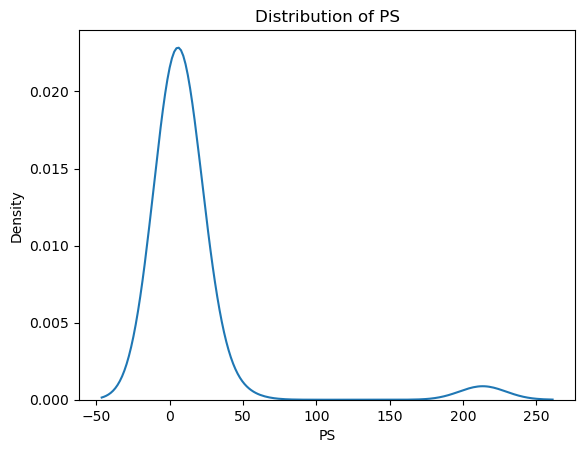

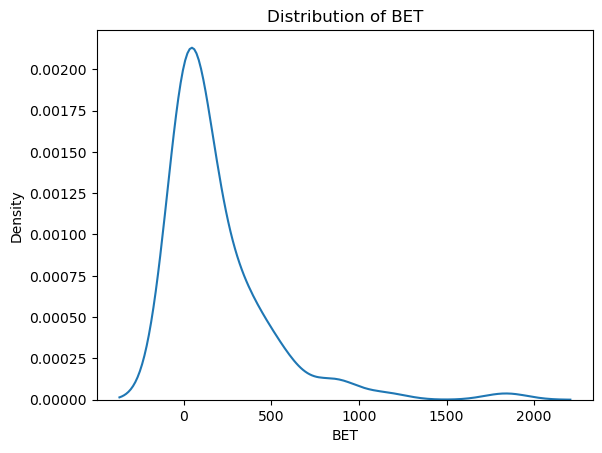

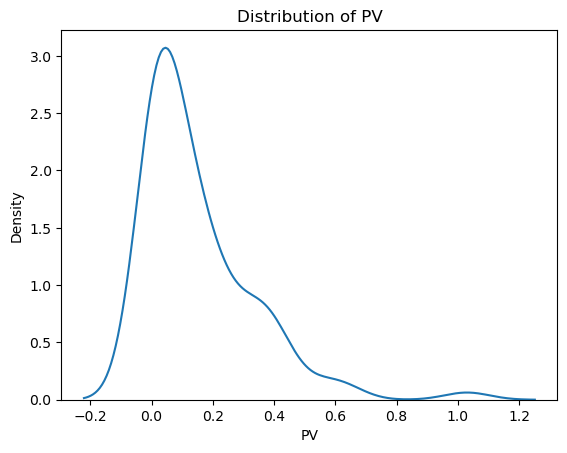

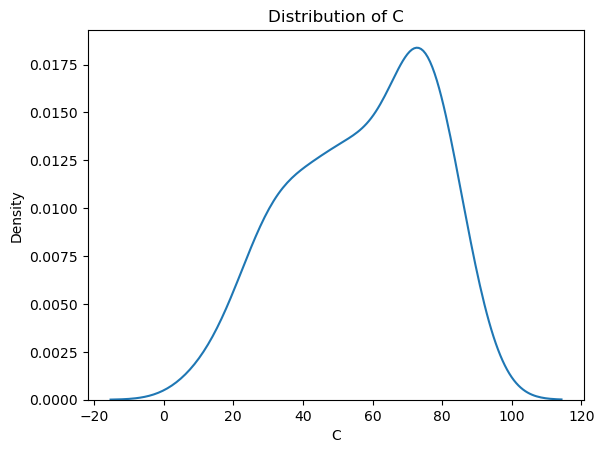

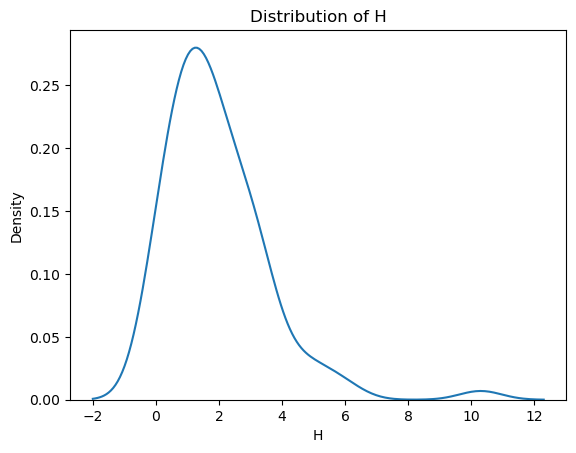

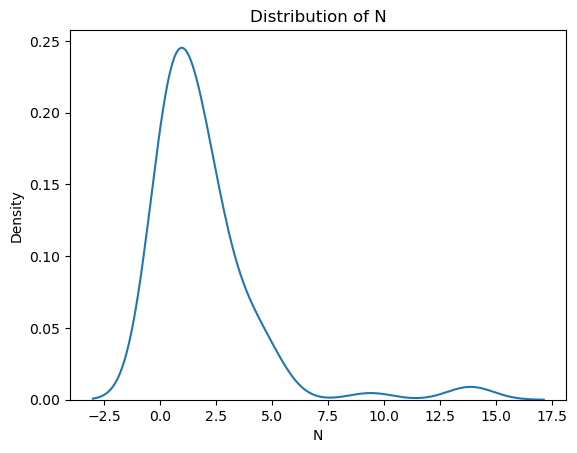

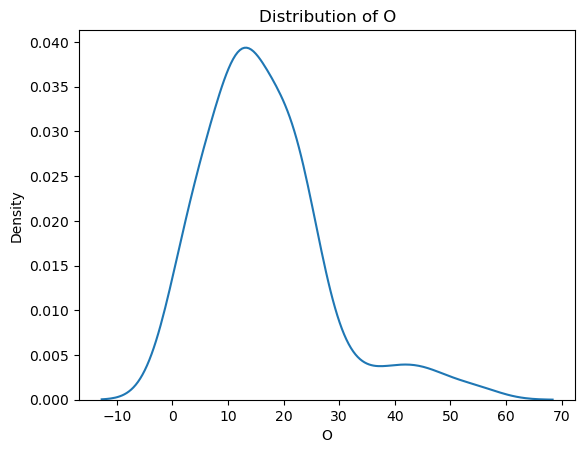

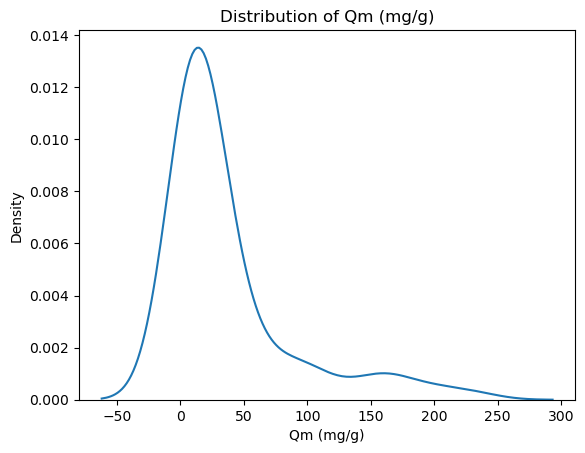

In [12]:
# Plot distributions of the features
def distplots(df):
    for col in df.columns:
        if df[col].dtype != object:
            if df[col].dtype == np.float64:
                sn.kdeplot(df[col])
            elif df[col].dtype == np.int64:
                sn.histplot(df[col])
            plt.title(f"Distribution of {col}")
            plt.show()
distplots(df)

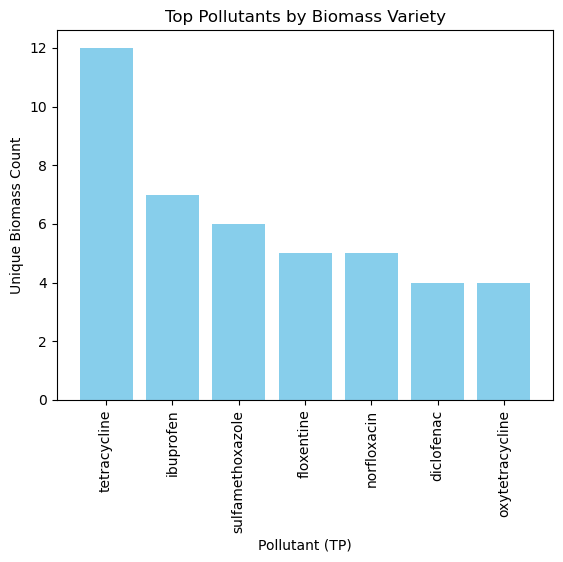

In [13]:
#removing spaces & converting into lower case
df['TP'] = df['TP'].str.strip().str.lower()
#grouping to see one pollutant is absorbed by different biomass.
TP_biomass = df.groupby('TP')['Biomass'].nunique().sort_values(ascending = False).reset_index().head(7)
plt.bar(TP_biomass['TP'], TP_biomass['Biomass'], color = 'skyblue')
plt.xlabel('Pollutant (TP)')
plt.ylabel('Unique Biomass Count')
plt.title('Top Pollutants by Biomass Variety')
plt.xticks(rotation=90)
plt.savefig("Top_5_Pollutants_by_Biomass_Variety.png", bbox_inches='tight')

In [14]:
#Biomass source classification
def process_biomass(biomass):
    biomass = biomass.lower()
    biomass = re.sub(r'[^\w\s]', '', biomass)  # Removes punctuation and special characters
    # Extract the last word
    last_word = biomass.split()[-1] 
    return last_word
df['raw_material'] = df['Biomass'].apply(process_biomass)
# Normalize 'Processed_Biomass' to count 'plant' and 'plants' as the same
df['raw_material'] = df['raw_material'].replace({'plants': 'plant'})


In [15]:
# Group by 'raw_materials' and count occurrences
grouped_counts = df.groupby('raw_material').size().sort_values(ascending = False).reset_index(name='Count')
html_str = grouped_counts.head(10).to_html(index=False)


In [16]:
#calculating correlation using pandas , pearson method
df_to_impute.corr(method='pearson') #only 'BET' & 'PV' columns are co-related

,TemP,Time (min),PS,BET,PV,C,N,H,O,Qm (mg/g)
TemP,1.000000,-0.120235,-0.181203,0.337013,0.179159,0.069188,0.057891,-0.367776,-0.289977,0.305999
Time (min),-0.120235,1.000000,-0.084362,-0.055130,0.031460,0.196529,-0.078409,0.015338,-0.018591,-0.125495
PS,-0.181203,-0.084362,1.000000,-0.154380,-0.141089,-0.048110,0.114764,0.128846,0.262212,0.020210
BET,0.337013,-0.055130,-0.154380,1.000000,0.789717,0.296669,0.152031,-0.114989,-0.056954,0.473991
PV,0.179159,0.031460,-0.141089,0.789717,1.000000,0.174309,0.280528,-0.067787,-0.047678,0.474331
C,0.069188,0.196529,-0.048110,0.296669,0.174309,1.000000,0.018156,0.189934,-0.026603,-0.056993
N,0.057891,-0.078409,0.114764,0.152031,0.280528,0.018156,1.000000,0.321310,-0.100710,0.292544
H,-0.367776,0.015338,0.128846,-0.114989,-0.067787,0.189934,0.321310,1.000000,0.228487,-0.023720
O,-0.289977,-0.018591,0.262212,-0.056954,-0.047678,-0.026603,-0.100710,0.228487,1.000000,0.021729
Qm (mg/g),0.305999,-0.125495,0.020210,0.473991,0.474331,-0.056993,0.292544,-0.023720,0.021729,1.000000


<Axes: >

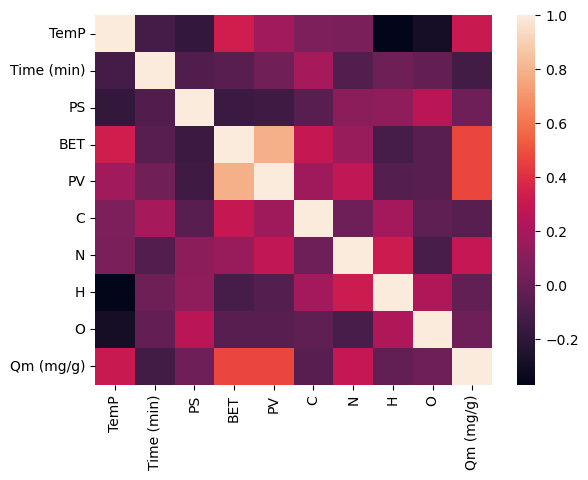

In [17]:
sn.heatmap(data = df_to_impute.corr())

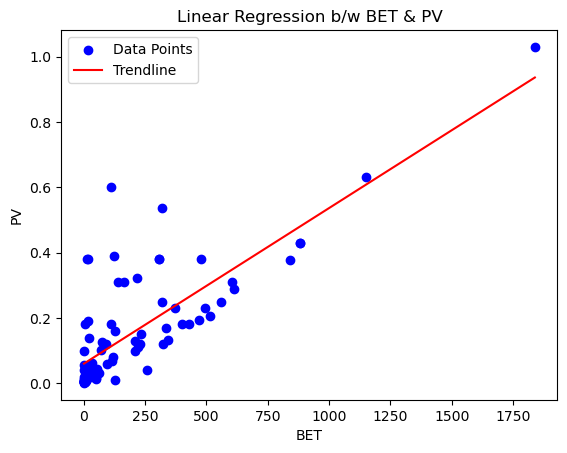

In [18]:
# Perform linear regression on the BET and PV columns
slope, intercept, r_value, p_value, std_err = linregress(df['BET'], df['PV'])

# Generate x values (BET) for plotting the regression line
x_values = np.linspace(df['BET'].min(), df['BET'].max(), 100)
# Calculate y values (PV) based on the regression equation
y_values = slope * x_values + intercept

#scatter plot
plt.scatter(df['BET'], df['PV'], label='Data Points', color='blue')

#trendline
plt.plot(x_values, y_values, color='red', label='Trendline')

# Add labels and legend
plt.xlabel('BET')
plt.ylabel('PV')
plt.title('Linear Regression b/w BET & PV')
plt.legend()
plt.savefig("BET & PV")

/Users/nandipatioohasripriya/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


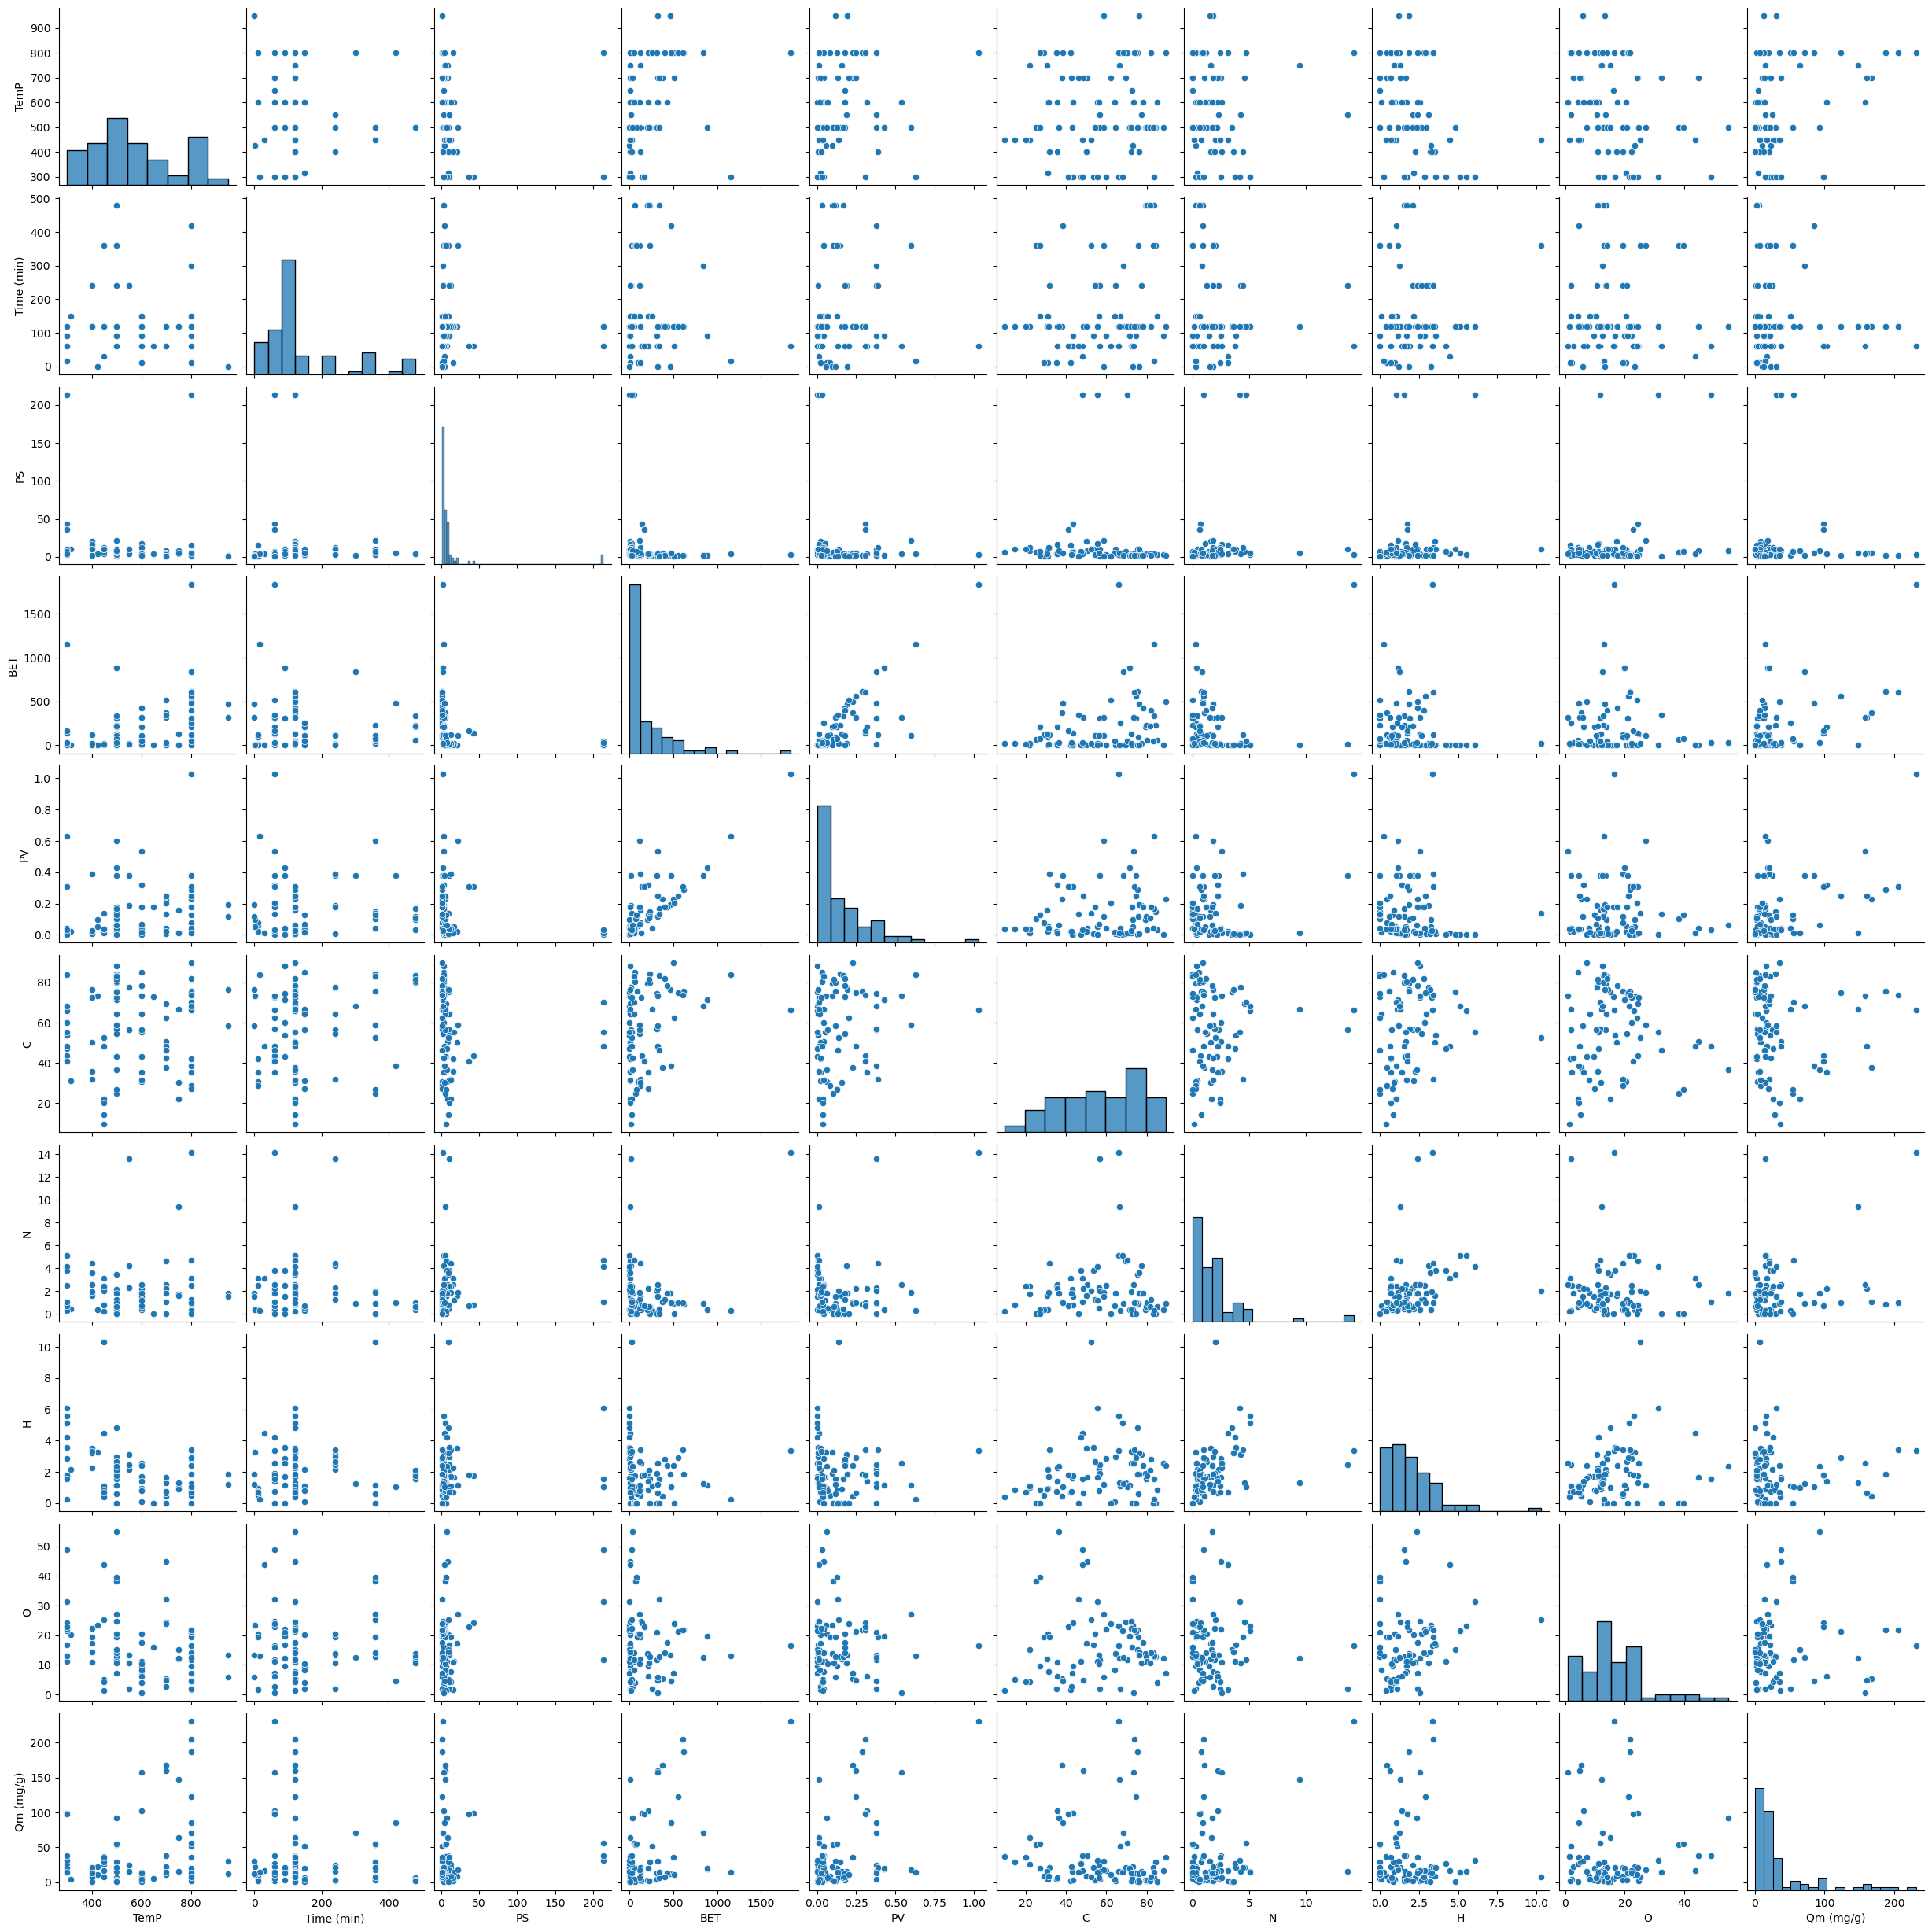

In [19]:
# Plot pairplot to create scatter plots between all numerical variables
sn.pairplot(df[numeric_columns])

# Display the plot
plt.show()

In [20]:
len(df['raw_material'].unique())

34

In [21]:
len(df['TP'].unique())

17

In [22]:
le = LabelEncoder()
df['Biomass_encoded'] = le.fit_transform(df['Biomass'])
df['TP_encoded'] = le.fit_transform(df['TP'])
print(df[['Biomass', 'Biomass_encoded', 'TP', 'TP_encoded']].head())


                     Biomass  Biomass_encoded          TP  TP_encoded
0       Waste sludge (paper)               32  citalopram           2
1       Waste sludge (paper)               32  citalopram           2
2       Waste sludge (paper)               32  citalopram           2
3  Waste sludge (Biological)               31  citalopram           2
4  Waste sludge (Biological)               31  citalopram           2


In [23]:
df = df.drop(['Biomass', 'TP' , 'raw_material'], axis=1)


In [24]:
df

,TemP,Time (min),PS,BET,PV,C,H,N,O,Qm (mg/g),Biomass_encoded,TP_encoded
0,315.0,150.0,9.82,3.43,0.02000,30.84,2.14,0.430,20.32,4.400,32,2
1,600.0,10.0,1.37,94.39,0.06000,30.69,0.96,0.320,20.41,3.800,32,2
2,800.0,10.0,1.37,120.86,0.08000,28.81,0.47,0.330,19.29,8.500,32,2
3,800.0,150.0,1.41,209.12,0.13000,27.05,0.82,0.330,9.73,19.600,31,2
4,800.0,10.0,3.69,10.82,0.02000,35.35,0.72,2.470,2.01,4.300,31,2
...,...,...,...,...,...,...,...,...,...,...,...,...
81,300.0,60.0,213.29,28.13,0.03125,48.13,1.53,1.000,48.96,37.803,25,15
82,700.0,60.0,1.32,513.00,0.20500,62.27,0.00,0.000,24.01,10.510,43,6
83,700.0,60.0,1.32,342.00,0.13200,46.13,0.00,0.000,32.25,13.870,43,6
84,800.0,300.0,2.25,841.00,0.37800,68.27,1.24,0.880,12.39,70.800,33,6


In [25]:
df['PS_log'] = np.log(df['PS'] + 1) 

In [26]:
X = df.drop(['Qm (mg/g)', 'BET', 'PS'], axis =1)  # drop the features according to our EDA results
y = df['Qm (mg/g)']  # Target

In [27]:
#standardization 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [28]:

# Add a constant to the model (for the intercept)
X_standardized = sm.add_constant(X_scaled)

# Fit the model
model = sm.OLS(y, X_standardized).fit()

# Get the model summary
model_summary = model.summary()
print(model_summary)

# Get the coefficients
coefficients = model.params
print("\nCoefficients:\n", coefficients)

                            OLS Regression Results                            
Dep. Variable:              Qm (mg/g)   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     6.194
Date:                Fri, 11 Oct 2024   Prob (F-statistic):           7.94e-07
Time:                        12:42:43   Log-Likelihood:                -433.02
No. Observations:                  86   AIC:                             888.0
Df Residuals:                      75   BIC:                             915.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.7356      4.295      8.553      0.0

In [29]:
#Import packages
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error,  make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, KFold, cross_validate, cross_val_predict
from random import randint
import warnings
import seaborn as sns
warnings.filterwarnings('ignore') 
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning # Import ConvergenceWarning
from joblib import parallel_backend
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [30]:
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error'] #Our major scorings

# Untuned Randomforest Regressor  

In [31]:
#untuned cross validation
default_rf = RandomForestRegressor(random_state=42)
k_folds = KFold(n_splits = 5)

untuned_mae_result = cross_val_score(default_rf, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error")
untuned_rmse_result = cross_val_score(default_rf, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")
#untuned_r2_result = cross_val_score(default_rf, X, y.values.ravel(), cv = k_folds, scoring= "r2")

In [32]:
average_untuned_mae_rf = np.mean(untuned_mae_result) *-1
average_untuned_rmse_rf = np.mean(np.sqrt(untuned_rmse_result*-1))

In [33]:
print(average_untuned_mae_rf)
print(average_untuned_rmse_rf)

32.83807558758169
46.5621829173488


# Tuned Randomforest Regressor with gridsearchcv

In [34]:
# Define the parameter grid to search through
rf_regressor = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [15, 25, 50, 100, 150],
    'max_depth': [None, 6, 8],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV with cross-validation on the training set
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid,
                           scoring=scoring, refit="neg_mean_squared_error", cv=5, verbose=1, n_jobs=-1, return_train_score=False)

# Perform the grid search on the training set
grid_search.fit(X, y)

# Extract the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters: ", best_params)

# Extract cross-validation results
cv_results = pd.DataFrame(grid_search.cv_results_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Hyperparameters:  {'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 25}


In [35]:
rf_mae = cv_results[f'mean_test_neg_mean_absolute_error'] * -1
rf_rmse = np.sqrt(cv_results[f'mean_test_neg_mean_squared_error'] * -1)

In [36]:
mean_rf_mae = rf_mae.mean()
mean_rf_rmse = rf_rmse.mean()
print(f'mae score: {mean_rf_mae}')
print(f'rmse score: {mean_rf_rmse}')

mae score: 33.76145213038821
rmse score: 50.354296749655816


In [54]:
#cross validation Evaluation 
k_folds = KFold(n_splits = 5)
k_rf_mae = cross_val_score(grid_search.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error") * -1
#rf_r2 = cross_val_score(grid_search.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "r2")
k_rf_rmse = np.sqrt(cross_val_score(grid_search.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")*-1)
print(f'k_mae score: {np.mean(k_rf_mae)}')
print(f'k_rmse score: {np.mean(k_rf_rmse)}')

k_mae score: 33.388195104793475
k_rmse score: 45.69841644761696


In [38]:
rf_results = {
    "Tunned": { "rmse": k_rf_rmse, "mae": k_rf_mae},
    "Untunned": { "rmse": np.sqrt(untuned_rmse_result*-1), "mae": untuned_mae_result *-1}
}

In [39]:
rf_results

{'Tunned': {'rmse': array([42.63562175, 54.32833587, 25.15004073, 36.23302317, 70.14506072]),
  'mae': array([29.72228184, 37.55081272, 21.99875113, 24.44650161, 53.22262822])},
 'Untunned': {'rmse': array([42.97253447, 50.17432777, 23.08501098, 38.52182735, 78.05721402]),
  'mae': array([27.61172506, 35.11329535, 19.49505941, 23.77679747, 58.19350065])}}

# Untunned xgboost

In [40]:
#using cross validation.
untunned_xgb_model = XGBRegressor(n_estimators = 200, learning_rate = 0.001)

In [41]:
kfold = KFold(n_splits=5)
# untunned_r2_results_xgb = cross_val_score(untunned_xgb_model, X, y, cv=kfold, scoring = 'r2')
untunned_rmse_results_xgb = np.sqrt(cross_val_score(untunned_xgb_model, X, y, cv=kfold, scoring = 'neg_mean_squared_error')*-1)
untunned_mae_results_xgb = cross_val_score(untunned_xgb_model, X, y, cv=kfold, scoring = 'neg_mean_absolute_error')*-1

In [42]:
np.mean(untunned_rmse_results_xgb)

48.043350964193394

In [43]:
np.mean(untunned_mae_results_xgb)

36.68996025591283

# Finetuning with randomsearchcv

In [44]:
xgb_reg = XGBRegressor()
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_lambda': [0, 0.1, 0.2, 0.3, 0.4]
}

random_search_xgb = RandomizedSearchCV(xgb_reg, param_distributions=param_dist, n_iter=50, scoring='r2', cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search_xgb.fit(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'reg_alpha': [0, 0.1, 0.2, 0.3, 0.4],
                                        'reg_lambda': [0, 0.1, 0.2, 0.3, 0.4],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='r2', verbose=1)

In [45]:
k_folds = KFold(n_splits = 5)
xgb_mae = cross_val_score(random_search_xgb.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error") * -1
xgb_rmse = np.sqrt(cross_val_score(random_search_xgb.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")*-1)

In [46]:
xgb_results = {
    "Tunned": { "rmse": xgb_rmse, "mae": xgb_mae},
    "Untunned": { "rmse": untunned_rmse_results_xgb, "mae": untunned_mae_results_xgb}
}
xgb_results

{'Tunned': {'rmse': array([27.35479019, 58.28972462, 37.20151139, 33.04509119, 79.6444981 ]),
  'mae': array([25.80575335, 38.84762221, 32.52467023, 21.73109727, 60.60265664])},
 'Untunned': {'rmse': array([30.53947695, 58.49841862, 35.82282716, 33.39599713, 81.96003496]),
  'mae': array([28.63348056, 39.16253433, 30.95349494, 22.36199513, 62.33829632])}}

#  Untunned gradient boost

In [47]:
gbr = GradientBoostingRegressor(loss='absolute_error',
                                learning_rate=0.01,
                                n_estimators=1000,
                                max_depth = 6, 
                                random_state = 42,
                                max_features = 5)

In [48]:
kfold = KFold(n_splits=5)
# untunned_r2_results_xgb = cross_val_score(untunned_xgb_model, X, y, cv=kfold, scoring = 'r2')
untunned_rmse_results_xgb = np.sqrt(cross_val_score(untunned_xgb_model, X, y, cv=kfold, scoring = 'neg_mean_squared_error')*-1)
untunned_mae_results_xgb = cross_val_score(untunned_xgb_model, X, y, cv=kfold, scoring = 'neg_mean_absolute_error')*-1

# Finetuning with Randomsearchcv

In [49]:
scoring = {
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',  # Ensure this matches your key
    'r2': 'r2'
}

param_dist = {
    'n_estimators': np.arange(50, 201, 50),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': np.arange(3, 11, 2),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'subsample': np.linspace(0.6, 1.0, 5)
}

# Define 5-fold cross-validation
k_folds = KFold(n_splits=5)
random_search_gbr = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(),
    param_distributions=param_dist,
    scoring=scoring,
    refit='neg_root_mean_squared_error',  # Use RMSE for refitting the best model
    n_iter=100,  # Number of parameter settings sampled
    cv=k_folds,  # 5-fold cross-validation
    random_state=42,
    n_jobs=-1  # Use all available cores
)
random_search_gbr.fit(X, y)
best_params_gbr = random_search_gbr.best_params_
cv_results_gbr = pd.DataFrame(random_search_gbr.cv_results_)

In [50]:
k_folds = KFold(n_splits = 5)
xgb_mae = cross_val_score(random_search_xgb.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_absolute_error") * -1
# xgb_r2 = cross_val_score(random_search_xgb.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "r2")
xgb_rmse = np.sqrt(cross_val_score(random_search_xgb.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")*-1)

In [51]:
np.mean(xgb_mae)

35.90235993934781

In [52]:
np.mean(xgb_rmse)

47.10712309785874

In [53]:
gbr_mae = cv_results_gbr['mean_test_neg_mean_absolute_error'] * -1
mean_gbr_mae = gbr_mae.mean()
gbr_rmse = np.sqrt(cv_results_gbr['mean_test_neg_root_mean_squared_error'] * -1)
mean_gbr_rmse = gbr_rmse.mean()

# Print the results
print("Mean Absolute Error (MAE):", mean_gbr_mae)
print("Root Mean Squared Error (RMSE):", mean_gbr_rmse)


Mean Absolute Error (MAE): 33.988750224609795
Root Mean Squared Error (RMSE): 6.705531984701516
